In [1]:
import logging

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)

from randnn import ContinuousNN, get_attractor_dimension
from randnn.plotting import *

In [2]:

COUPLING_STRENGTH = .1
N_NEURONS = 1000

In [3]:
cont_nn = ContinuousNN(coupling_strength=COUPLING_STRENGTH, n_dofs=N_NEURONS, max_step=0.1)

/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle((0, 0),


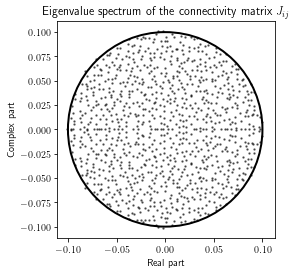

In [4]:
# Plot the eigenvalue spectrum and make sure it respects Girko's circular law
plot_random_matrix_spectrum(cont_nn.coupling_matrix, COUPLING_STRENGTH)

In [5]:
trajectory = cont_nn.run_or_load(n_steps=1000, n_burn_in=200)
cont_nn.save(trajectory)

Generating samples: 100%|██████████| 1000/1000 [00:01<00:00, 713.91it/s]


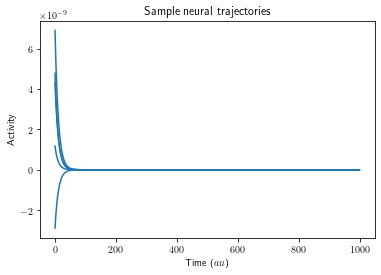

In [6]:
plot_trajectory_samples(trajectory, 5)

In [7]:
#logging.basicConfig(level=logging.INFO)
lyapunov_spectrum = cont_nn.get_lyapunov_spectrum(trajectory)

Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [01:31, 10.88it/s]


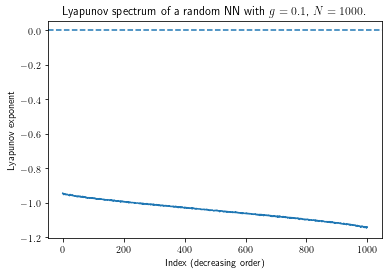

In [8]:
plot_lyapunov_spectrum(lyapunov_spectrum, title="Lyapunov spectrum of a random NN with $g={}$, $N={}$.".format(COUPLING_STRENGTH, N_NEURONS))

In [9]:
def get_attractor_dimension(lyapunov_spectrum: np.ndarray) -> float:
    """
    The attractor dimensionality is given by the interpolated number of Lyapunov exopnents that sum to $0$

    This assumes that lyapunov_spectrum is already in decreasing order.
    """
    k = 0
    _sum = 0

    while _sum >= 0 and k < lyapunov_spectrum.size -1:
        _sum += lyapunov_spectrum[k]
        k += 1

    _sum -= lyapunov_spectrum[k - 1]

    return k + _sum / np.abs(lyapunov_spectrum[k])  # Python counts from 0!

print("Attractor dimension: {}".format(get_attractor_dimension(lyapunov_spectrum)))

Attractor dimension: 1.0


In [10]:
def scaling_analysis():
    scaling_vars = [10,100,1000]
    analysis_fns = [plot_lyapunov_spectrum, get_attractor_dimension]
    
    results = []
    for scaling_var in scaling_vars:
        _results = []
        system = ContinuousNN(coupling_strength=COUPLING_STRENGTH, n_dofs=scaling_var, max_step=0.001)
        #system = ContinuousNN(coupling_strength=scaling_var, n_dofs=N_NEURONS, max_step=0.001))
        trajectory = system.run_or_load(n_steps=10000, n_burn_in=200)
        spectrum = system.get_lyapunov_spectrum(trajectory)

        for fn in analysis_fns:
            _results.push(fn(trajectory))

        results.push((scaling_var, _results))

    return results

In [11]:
q, r= np.linalg.qr(np.random.uniform(size=(5,5)))

r

array([[-1.10802997, -0.75728672, -0.82011703, -0.97757779, -0.36795541],
       [ 0.        ,  0.24152995,  0.51731728,  0.08488942,  0.7913153 ],
       [ 0.        ,  0.        ,  1.13713731,  0.65957599,  1.11232738],
       [ 0.        ,  0.        ,  0.        , -0.56677859, -0.37307129],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.02205515]])